# **Plant Disease Classification with Top-3 Evaluation**


In [ ]:
!pip install lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 821.1/821.1 kB 27.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 84.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 58.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 34.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 29.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 67.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal

In [ ]:
import os
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split
from torch.utils.data import DataLoader, Dataset, Subset
from torch.utils.data import random_split, SubsetRandomSampler
from torchvision import datasets, transforms, models
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid

#the latest environement
from lightning.pytorch import LightningModule
from lightning.pytorch import LightningDataModule
from lightning.pytorch import Trainer
import lightning.pytorch as L
print(L.__version__)

import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from PIL import Image

2.5.2


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np

2025-08-12 05:59:21.453059: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754978361.678057      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754978361.738473      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
dir0='/kaggle/input/plant-disease-detection/Dataset'

In [ ]:
classes=[]
paths=[]
for dirname, _, filenames in os.walk(dir0):
    for filename in filenames:
        if filename.endswith('.JPG'):
            classes+=[dirname.split('/')[-1]]
            paths+=[(os.path.join(dirname, filename))]

In [ ]:
dataset0=datasets.ImageFolder(root=dir0)
class_names=dataset0.classes
print(class_names)
print(len(class_names))

['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']
23


In [ ]:
N=list(range(len(classes)))
normal_mapping=dict(zip(class_names,N))
reverse_mapping=dict(zip(N,class_names))

data=pd.DataFrame(columns=['path','class','label'])
data['path']=paths
data['class']=classes
data['label']=data['class'].map(normal_mapping)
print(len(data))

33290


In [ ]:
transform=transforms.Compose([
        transforms.RandomRotation(10),      # rotate +/- 10 degrees
        transforms.RandomHorizontalFlip(),  # reverse 50% of images
        transforms.Resize(224),             # resize shortest side to 224 pixels
        transforms.CenterCrop(224),         # crop longest side to 224 pixels at center
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
])

In [ ]:
def create_path_label_list(df):
    path_label_list = []
    for _, row in df.iterrows():
        path = row['path']
        label = row['label']
        path_label_list.append((path, label))
    return path_label_list

path_label = create_path_label_list(data)
path_label = random.sample(path_label,len(path_label))
print(len(path_label))
print(path_label[0:3])

33290
[('/kaggle/input/plant-disease-detection/Dataset/Apple___healthy/c5a79e4d-e008-452d-b71d-503ef9077903___RS_HL 8027_flipTB.JPG', 3), ('/kaggle/input/plant-disease-detection/Dataset/Apple___healthy/f31086c2-e23e-4ae1-85a4-89eb742271bc___RS_HL 7611_flipTB.JPG', 3), ('/kaggle/input/plant-disease-detection/Dataset/Apple___Black_rot/5386aabe-1e7f-4688-ac5e-ade0e91318d4___JR_FrgE.S 8638_new30degFlipLR.JPG', 1)]


In [ ]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, path_label, transform=None):
        self.path_label = path_label
        self.transform = transform

    def __len__(self):
        return len(self.path_label)

    def __getitem__(self, idx):
        path, label = self.path_label[idx]
        img = Image.open(path).convert('RGB')

        if self.transform is not None:
            img = self.transform(img)

        return img, label

In [ ]:
class DataModule(LightningDataModule):
    def __init__(self, path_label, batch_size=32):
        super().__init__()
        self.path_label = path_label
        self.batch_size = batch_size
        self.transform = transforms.Compose([
            transforms.Resize(224),             # resize shortest side to 224 pixels
            transforms.CenterCrop(224),         # crop longest side to 224 pixels at center
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],
                                 [0.229, 0.224, 0.225])
        ])
        self.train_dataset = None
        self.val_dataset = None

    def setup(self, stage=None):
        # Use CustomDataset that takes path_label instead of ImageFolder if needed
        dataset = CustomDataset(self.path_label, self.transform)

        # Split dataset into train and validation sets
        dataset_size = len(dataset)
        train_size = int(0.5 * dataset_size)
        val_size = dataset_size - train_size
        print(f"Train size: {train_size}, Validation size: {val_size}")

        self.train_dataset = Subset(dataset, range(train_size))
        self.val_dataset = Subset(dataset, range(train_size, dataset_size))

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size)

    # If you also need a test dataloader, you can add:
    def test_dataloader(self):
        return self.val_dataloader()  # Or implement a separate test dataset if needed

In [ ]:
import timm

class ConvolutionalNetwork(LightningModule):

    def __init__(self, num_classes):
        super().__init__()
        self.base_model = timm.create_model('resnet18',
                                            pretrained=True,
                                            num_classes=len(class_names))

    def forward(self, x):
        return self.base_model(x)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        return optimizer

    def training_step(self, train_batch, batch_idx):
        X, y = train_batch
        y_hat = self(X)
        loss = F.cross_entropy(y_hat, y)
        self.log("train_loss", loss)
        return loss

    def validation_step(self, val_batch, batch_idx):
        X, y = val_batch
        y_hat = self(X)
        loss = F.cross_entropy(y_hat, y)
        pred = y_hat.argmax(dim=1, keepdim=True)
        acc = pred.eq(y.view_as(pred)).sum().item() / y.shape[0]
        self.log("val_loss", loss)
        self.log("val_acc", acc)


    # Adapt the test step for Top-3 evaluation
    def test_step(self, test_batch, batch_idx):
        X, y = test_batch
        y_hat = self(X)
        loss = F.cross_entropy(y_hat, y)

        # Get Top-3 predictions
        _, top3_pred = y_hat.topk(3, dim=1)

        # Count as correct if the true label is in the Top-3 predictions
        correct = top3_pred.eq(y.view(-1, 1).expand_as(top3_pred)).any(dim=1)
        acc = correct.float().mean().item()

        self.log("test_loss", loss)
        self.log("test_acc_top3", acc)  # Change metric name to distinguish


In [ ]:
if __name__ == '__main__':
    datamodule = DataModule(path_label=path_label)
    datamodule.setup()
    model = ConvolutionalNetwork(num_classes=len(class_names))

    trainer = L.Trainer(max_epochs=10)

    trainer.fit(model, datamodule)
    datamodule.setup(stage='test')
    test_loader = datamodule.test_dataloader()
    trainer.test(dataloaders=test_loader)

Train size: 16645, Validation size: 16645


model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO: 
  | Name       | Type   | Params | Mode 
----------------------------------------------
0 | base_model | ResNet | 11.2 M | train
----------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.753    Total estimated model params size (MB)
94        Modules in train mode
0         Modules in eval mode


Train size: 16645, Validation size: 16645


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=10` reached.
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:149: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
INFO: Restoring states from the checkpoint path at /kaggle/working/lightning_logs/version_0/checkpoints/epoch=9-step=5210.ckpt
INFO: Loaded model weights from the checkpoint at /kaggle/working/lightning_logs/version_0/checkpoints/epoch=9-step=5210.ckpt


Train size: 16645, Validation size: 16645
Train size: 16645, Validation size: 16645


/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_acc_top3       │    0.9987984299659729     │
│         test_loss         │    0.07340354472398758    │
└───────────────────────────┴───────────────────────────┘

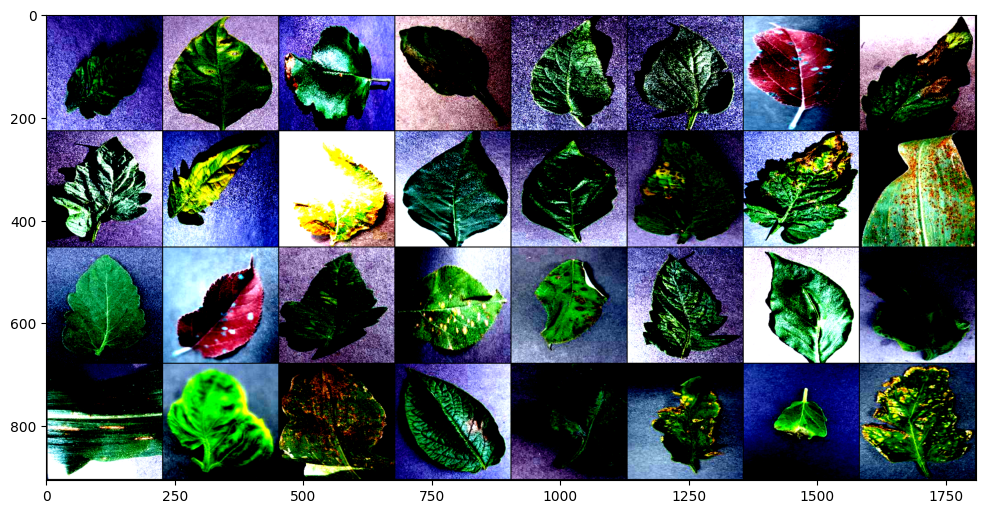

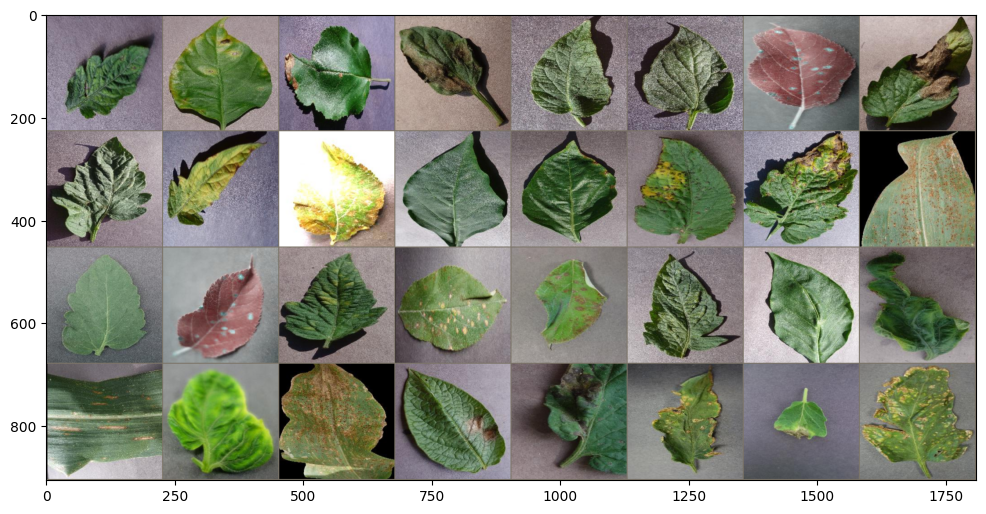

In [ ]:
for images, labels in datamodule.test_dataloader():
    break
im=make_grid(images,nrow=8)

plt.figure(figsize=(12,12))
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

inv_normalize=transforms.Normalize(mean=[-0.485/0.229,-0.456/0.224,-0.406/0.225],
                                   std=[1/0.229,1/0.224,1/0.225])
im=inv_normalize(im)

plt.figure(figsize=(12,12))
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

In [ ]:
# Adapt the final evaluation for Top-3 accuracy
device = torch.device("cpu")  # or "cuda:0"

model.eval()
y_true = []
y_pred_top1 = []
y_pred_top3 = []  # Store Top-3 predictions

with torch.no_grad():
    for test_data in datamodule.test_dataloader():
        test_images, test_labels = test_data[0].to(device), test_data[1].to(device)
        outputs = model(test_images)

        # Top-1 prediction
        _, pred_top1 = outputs.max(1)

        # Top-3 predictions
        _, pred_top3 = outputs.topk(3, dim=1)

        for i in range(len(pred_top1)):
            y_true.append(test_labels[i].item())
            y_pred_top1.append(pred_top1[i].item())
            y_pred_top3.append(pred_top3[i].tolist())

# Calculate Top-1 accuracy
correct_top1 = [true == pred for true, pred in zip(y_true, y_pred_top1)]
acc_top1 = sum(correct_top1) / len(correct_top1)

# Calculate Top-3 accuracy
correct_top3 = [true in pred for true, pred in zip(y_true, y_pred_top3)]
acc_top3 = sum(correct_top3) / len(correct_top3)

print(f"Top-1 Accuracy: {acc_top1:.4f}")
print(f"Top-3 Accuracy: {acc_top3:.4f}")

# Top-1 classification report
print("\nTop-1 Classification Report:")
print(classification_report(y_true, y_pred_top1, target_names=class_names, digits=4))

# Function to display Top-3 hit/miss results
def print_top3_hits(y_true, y_pred_top3, class_names):
    for i in range(min(10, len(y_true))):  # Show first 10 samples
        true_label = class_names[y_true[i]]
        pred_labels = [class_names[p] for p in y_pred_top3[i]]
        hit = "✓" if y_true[i] in y_pred_top3[i] else "✗"
        print(f"Sample {i}: True={true_label} | Pred={pred_labels} {hit}")

print("\nTop-3 Prediction Examples:")
print_top3_hits(y_true, y_pred_top3, class_names)


Top-1 Accuracy: 0.9784
Top-3 Accuracy: 0.9988

Top-1 Classification Report:
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab     0.9940    1.0000    0.9970       997
                                 Apple___Black_rot     0.9990    0.9980    0.9985       993
                          Apple___Cedar_apple_rust     1.0000    0.9845    0.9922       901
                                   Apple___healthy     0.9971    0.9961    0.9966      1021
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot     0.9942    0.9421    0.9674       725
                       Corn_(maize)___Common_rust_     0.9876    0.9990    0.9932       953
               Corn_(maize)___Northern_Leaf_Blight     0.9578    0.9925    0.9748       800
                            Corn_(maize)___healthy     1.0000    1.0000    1.0000        13
                     Pepper__bell___Bacterial_spot     1.0000    0.9757    0.9877       494
   